# TODO advanced topics:

- melt to facet by columns with seaborn. That is, melt multiple columns such as population, income etc to one variable and then used grids in seaborn to get these variables out next to each other in the grid plot.
- pd.cut to create categories of continous variables, i.e population or year intervals and use as categoricals when plotting.
- cumulative sum. sum CO2 over the years vs average CO2 of a year, all dots for many years, connect the as a time line and use size to know where the line starts, hue will be for the country. Choose top thn producers this year or something like that. also show cumulative as line plots over the years,  compare two line plots vs one timeline plot.
- add seaborn two dimensional KDE plots to the oversturateion section.
- the first plotting section has been moved to lec 3, would be cool to include 1-2 of the other plotting ideas mentioned above. The section after the plotting will stay the same I think.
- Potentially take over merge part from lec2 since it will not fit there, but not that important.

## Lesson preamble

### Lecture objectives

- Learn about tidy data.
- Transform data from the long to wide format.
- Understand which types of figures are suitable to create from raw data.
- Learn how to avoid common pitfalls when plotting large data sets.

### Lecture outline

- Reshaping with data with `pivot()`, `pivot_table()`, and `melt()` (40 min)
- Visualization tips and tricks
    - Changing plot appearance with `matplotlib` (35 min)
    - Avoiding saturated plots (40 min)
    - Choose informative plots for categorical data (35 min)
    - Making plots accessible through suitable color choices (10 min)

In [1]:
# Setup by loading the data set from the previous lecture
import pandas as pd

# If you don't have the dataset 
#surveys = pd.read_csv('https://ndownloader.figshare.com/files/2292169')

# If you have already downloaded the dataset
surveys = pd.read_csv('./surveys.csv')

surveys.head()

,record_id,month,day,year,plot_id,species_id,sex,hindfoot_length,weight,genus,species,taxa,plot_type
0,1,7,16,1977,2,NL,M,32.0,NaN,Neotoma,albigula,Rodent,Control
1,72,8,19,1977,2,NL,M,31.0,NaN,Neotoma,albigula,Rodent,Control
2,224,9,13,1977,2,NL,NaN,NaN,NaN,Neotoma,albigula,Rodent,Control
3,266,10,16,1977,2,NL,NaN,NaN,NaN,Neotoma,albigula,Rodent,Control
4,349,11,12,1977,2,NL,NaN,NaN,NaN,Neotoma,albigula,Rodent,Control


<!-- TODO I should talk about this during the data organization chapter also, maybe I can go into details, and this can be more like repetition? I shold mentioned splittign varibles. and to minimize storage space. -->

**TODO this will stay largely the same but with the seaborn plot in the end to show some plotting utility from melting.**

## Reshaping data between long and wide formats

Data is often presented in a so-called wide format, e.g. with one column per measurement:

|person|weight|height|age|
|------|------|------|---|
|A|70|170|32|
|B|85|179|28|

This can be a great way to display data so that it is easily interpretable by humans and is often used for summary statistics (commonly referred to as pivot tables). However, many data analysis functions in `pandas`, `seaborn` and other packages are optimized to work with the tidy data format. Tidy data is a long format where each row is a single observation and each column contains a single variable:

|person|measure|value|
|------|-----------|-----|
|     A|     weight|   70|
|     A|     height|  170|
|     A|        age|   32|
|     B|     weight|   85|
|     B|     height|  179|
|     B|        age|   28|

`pandas` enables a wide range of manipulations of the structure of data, including alternating between the long and wide format. The survey data presented here is in a tidy format. To facilitate visual comparisons of the relationships between measurements across columns, it would be beneficial to display this data in the wide format. For example, what is the relationship between mean weights of different species caught at the same plot type?

### Subset data

To facilitate the visualization of the the transformations between wide and tidy data,  it is beneficial to create a subset of the data.

In [2]:
species_sub = ['albigula', 'flavus', 'merriami']
col_sub = ['record_id', 'species', 'weight', 'plot_type']
surveys_sub = surveys.loc[surveys['species'].isin(species_sub), col_sub]
surveys_sub.head()

,record_id,species,weight,plot_type
0,1,albigula,NaN,Control
1,72,albigula,NaN,Control
2,224,albigula,NaN,Control
3,266,albigula,NaN,Control
4,349,albigula,NaN,Control


In [3]:
surveys_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13445 entries, 0 to 34083
Data columns (total 4 columns):
record_id    13445 non-null int64
species      13445 non-null object
weight       12962 non-null float64
plot_type    13445 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 525.2+ KB


### Long to wide with `pivot()` and `pivot_table()`

A long to wide transformation would be suitable to effectively visualize the relationship between the mean body weights of each species within the different plot types used to trap the animals. The first step in creating this table is to compute the mean weight for each species in each plot type.

In [4]:
surveys_sub_gsp = (
    surveys_sub
        .groupby(['species', 'plot_type'])['weight']
        .mean()
        .reset_index()
)
surveys_sub_gsp

,species,plot_type,weight
0,albigula,Control,159.349005
1,albigula,Long-term Krat Exclosure,156.933775
2,albigula,Rodent Exclosure,168.943262
3,albigula,Short-term Krat Exclosure,155.051948
4,albigula,Spectab exclosure,157.842105
5,flavus,Control,7.758537
6,flavus,Long-term Krat Exclosure,7.872340
7,flavus,Rodent Exclosure,8.056604
8,flavus,Short-term Krat Exclosure,8.221007
9,flavus,Spectab exclosure,7.187500


To remove the repeating information for `species` and `plot_type`, this table can be pivoted into a wide formatted using the `pivot()` method. The arguments passed to `pivot()` includes the rows (the index), the columns, and which values should populate the table. 

In [5]:
surveys_sub_gsp.pivot(index='plot_type', columns='species', values='weight')

species,albigula,flavus,merriami
plot_type,,,
Control,159.349005,7.758537,43.385366
Long-term Krat Exclosure,156.933775,7.872340,43.292453
Rodent Exclosure,168.943262,8.056604,42.324910
Short-term Krat Exclosure,155.051948,8.221007,42.446251
Spectab exclosure,157.842105,7.187500,43.131443


Compare how this table is displayed with the table in the previous cell. It is certainly easier to spot differences between the species and plot types in this wide format.

Since presenting summary statistics in a wide format is such a common operation, `pandas` has a dedicated method, `pivot_table()`, that performs both the data aggregation and pivoting.

In [6]:
surveys_sub.pivot_table(index='plot_type', columns='species', values='weight')

species,albigula,flavus,merriami
plot_type,,,
Control,159.349005,7.758537,43.385366
Long-term Krat Exclosure,156.933775,7.872340,43.292453
Rodent Exclosure,168.943262,8.056604,42.324910
Short-term Krat Exclosure,155.051948,8.221007,42.446251
Spectab exclosure,157.842105,7.187500,43.131443


Although `pivot_table()` is the most convenient way to aggregate *and* pivot data, `pivot()` is still useful to reshape a data frame from wide to long *without* performing aggregation.

With the data in a wide format, the pairwise correlations between the columns can be computed using `corr()`.

In [7]:
surveys_sub_pvt = surveys_sub.pivot_table(index='plot_type', columns='species', values='weight')
surveys_sub_pvt.corr()

species,albigula,flavus,merriami
species,,,
albigula,1.000000,0.160123,-0.454296
flavus,0.160123,1.000000,-0.606458
merriami,-0.454296,-0.606458,1.000000


The columns and rows can be swapped in the call to `pivot_table()`. This is useful both to present the table differently and to perform computations on a different axis (dimension) of the data frame (this result can also be obtained by calling the `transpose()` method of `subveys_sub`).

In [8]:
surveys_sub.pivot_table(index='species', columns='plot_type', values='weight')

plot_type,Control,Long-term Krat Exclosure,Rodent Exclosure,Short-term Krat Exclosure,Spectab exclosure
species,,,,,
albigula,159.349005,156.933775,168.943262,155.051948,157.842105
flavus,7.758537,7.872340,8.056604,8.221007,7.187500
merriami,43.385366,43.292453,42.324910,42.446251,43.131443


With `pivot_table()` it is also possible to add the total sums for all rows and columns, and to change the aggregation function.

In [9]:
surveys_sub.pivot_table(index='plot_type', columns='species', values='weight', margins=True, aggfunc='median')

species,albigula,flavus,merriami,All
plot_type,,,,
Control,164.0,8.0,44.0,44.0
Long-term Krat Exclosure,161.0,8.0,44.0,9.0
Rodent Exclosure,171.0,8.0,43.0,44.0
Short-term Krat Exclosure,162.0,8.0,43.0,42.0
Spectab exclosure,157.5,7.0,44.0,44.0
All,164.0,8.0,44.0,44.0


### Wide to long with `melt()`

It is also a common operation to reshape data from the wide to the long format, e.g. when getting the data into the most suitable format for analysis. For this transformation, the `melt()` method can be used to sweep up a set of columns into one key-value pair.

To prepare the data frame, the `plot_type` index name can be moved to a column name with the `reset_index()` method.

In [10]:
surveys_sub_pvt

species,albigula,flavus,merriami
plot_type,,,
Control,159.349005,7.758537,43.385366
Long-term Krat Exclosure,156.933775,7.872340,43.292453
Rodent Exclosure,168.943262,8.056604,42.324910
Short-term Krat Exclosure,155.051948,8.221007,42.446251
Spectab exclosure,157.842105,7.187500,43.131443


In [11]:
surveys_sub_pvt = surveys_sub_pvt.reset_index()
surveys_sub_pvt

species,plot_type,albigula,flavus,merriami
0,Control,159.349005,7.758537,43.385366
1,Long-term Krat Exclosure,156.933775,7.872340,43.292453
2,Rodent Exclosure,168.943262,8.056604,42.324910
3,Short-term Krat Exclosure,155.051948,8.221007,42.446251
4,Spectab exclosure,157.842105,7.187500,43.131443


At a minimum, `melt()` only requires the name of the column that should be kept intact. All remaining columns will have their values in the `value` column and their name in the `variable` column (here, our columns already has a name "species", so this will be used automatically instead of "variable").

In [12]:
surveys_sub_pvt.melt(id_vars='plot_type')

,plot_type,species,value
0,Control,albigula,159.349005
1,Long-term Krat Exclosure,albigula,156.933775
2,Rodent Exclosure,albigula,168.943262
3,Short-term Krat Exclosure,albigula,155.051948
4,Spectab exclosure,albigula,157.842105
5,Control,flavus,7.758537
6,Long-term Krat Exclosure,flavus,7.872340
7,Rodent Exclosure,flavus,8.056604
8,Short-term Krat Exclosure,flavus,8.221007
9,Spectab exclosure,flavus,7.187500


To be more explicit, all the arguments to `melt()` can be specified. This way it is also possible to exclude some columns, e.g. the species 'merriami'.

In [13]:
surveys_sub_pvt.melt(id_vars='plot_type', value_vars=['albigula', 'flavus'], 
                     var_name='species', value_name='weight')

,plot_type,species,weight
0,Control,albigula,159.349005
1,Long-term Krat Exclosure,albigula,156.933775
2,Rodent Exclosure,albigula,168.943262
3,Short-term Krat Exclosure,albigula,155.051948
4,Spectab exclosure,albigula,157.842105
5,Control,flavus,7.758537
6,Long-term Krat Exclosure,flavus,7.872340
7,Rodent Exclosure,flavus,8.056604
8,Short-term Krat Exclosure,flavus,8.221007
9,Spectab exclosure,flavus,7.187500


>#### Challenge 1
>
>1. Make a wide data frame with `year` as columns, `plot_id` as rows, where the values are the number of genera per plot. *Hint* Remember how `nunique()` from last lecture. You will also need to reset the index before pivoting.
>
>2. Now take that data frame, and make it long again, so each row is a unique `plot_id` - `year` combination.

# Visualization tips and tricks

**NOTE the first section here has been moved to lec 3, would be cool to include 1-2 of the other plotting ideas mentioned in on top**

## Avoiding saturated plots

Summary plots (especially bar plots) were previously mentioned to potentially be misleading, and it is often most appropriate to show every individual observation with a dot plot or the like, perhaps combined with summary markers where appropriate. But, what if the data set is too big to visualize every single observations? In large data sets, it is often the case that plotting each individual observation would oversaturate the chart.  

To illustrate saturation and how it can be avoided, load the datasets `diamonds` from the R sample data set repository:

In [28]:
diamonds = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/ggplot2/diamonds.csv', index_col=0)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [29]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


When plotting a data frame, `matplotlib` plotting functions can be made aware of the structure of the data by specifying the `data` parameter and the `x` and `y` parameters can then be specified just by passing the name of a column in the data frame as a string.

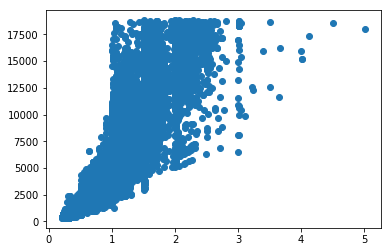

In [30]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds)

Because this is a dataset with 53,940 observations, visualizing it in two dimensions creates a graph that is incredibly oversaturated. Oversaturated graphs make it *far more* difficult to glean information from the visualization. Maybe adjusting the size of each observation could help?

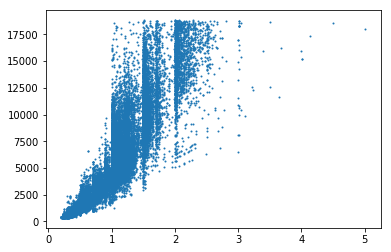

In [31]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1)

That's a bit better. Reducing the transparency might help further.

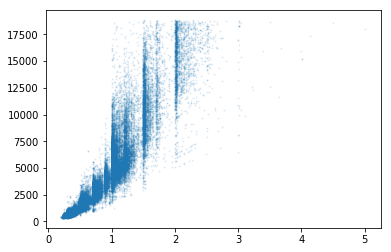

In [32]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1, alpha=0.1)

This is clearer than initially, but does still not reveal the full structure of the underlying data. Before proceeding, add axis labels and remove the axis lines (spines) on the top and the right.

Text(0,0.5,'Price')

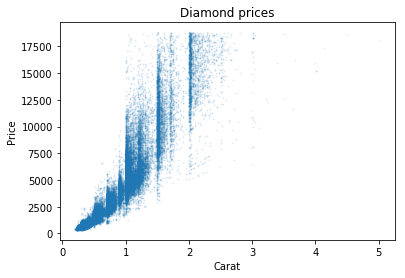

In [33]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1, alpha=0.1)

ax.set_title('Diamond prices')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')

The fontsizes of the labels and title are a bit small. They could be resizes separately, but the easiest way to change all of them is with the previously used `set_context()` function from `seaborn`. Here, `despine()` is also used to improve the visual appeal of the plot by removing the top and right axis spines.

Text(0,0.5,'Price')

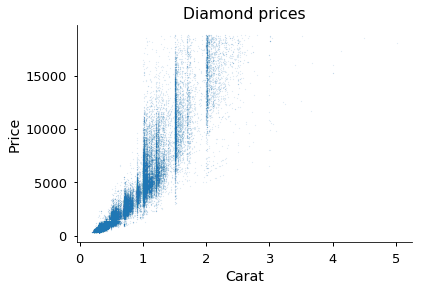

In [34]:
import seaborn as sns

sns.set_context('notebook', font_scale=1.3) # Increase all font sizes

fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1, alpha=0.1)
sns.despine()

ax.set_title('Diamond prices')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
# sns.despine() essentially does the following:
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

The x- and y-axis limits can be adjusted to zoom in on the denser areas of the plot.

(200, 4000)

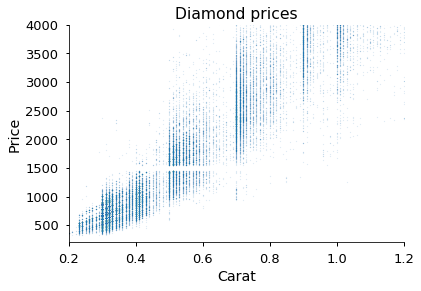

In [35]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1, alpha=0.1)
sns.despine()

ax.set_title('Diamond prices')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
ax.set_xlim(0.2, 1.2)
ax.set_ylim(200, 4000)

The result is still not satisfactory, which illustrates that a scatter plot is simply not a good choice with huge data sets. A more suitable plot type for this data, is a so called `hexbin` plot, which essentially is a two dimensional histogram, where the color of each hexagonal bin represents the amount of observations in that bin (analogous to the height in a one dimensional histogram). 

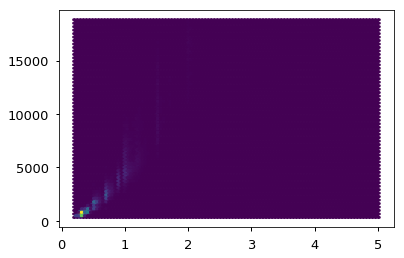

In [36]:
fig, ax = plt.subplots()
ax.hexbin('carat', 'price', data=diamonds)

This looks ugly because the bins with zero observations are still colored. This can be avoided by setting the minimum count of observations to color a bin.

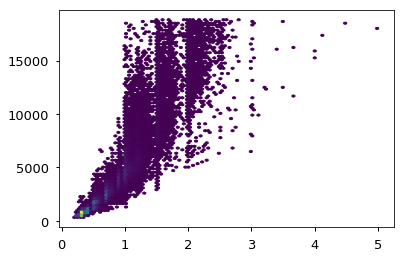

In [37]:
fig, ax = plt.subplots()
ax.hexbin('carat', 'price', data=diamonds, mincnt=1)

The distribution of the data is not more akin to that of the scatter plot. To know what the different colors represent, a colorbar needs to be added to this plot. The space for the colorbar will be taken from a plot in the current figure.

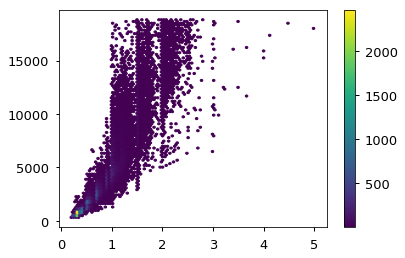

In [38]:
fig, ax = plt.subplots()
# Assign to a variable to reuse with the colorbar
hex_plot = ax.hexbin('carat', 'price', data=diamonds, mincnt=1)
# Create the colorbar from the hexbin plot axis
cax = fig.colorbar(hex_plot)

Notice that the overall figure is the same size, and the axes that contains the hexbin plot shrank to make room for the colorbar. To remind ourselves what is plotted, axis labels can be added like previously.

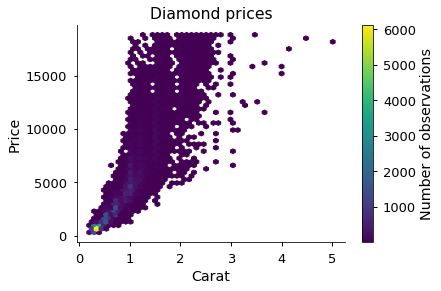

In [39]:
fig, ax = plt.subplots()
hex_plot = ax.hexbin('carat', 'price', data=diamonds, mincnt=1, gridsize=50)
sns.despine()
cax = fig.colorbar(hex_plot)

ax.set_title('Diamond prices')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
cax.set_label('Number of observations')

It is now clear that the yellow area represents over 2000 observations!

Text(0,0.5,'Price')

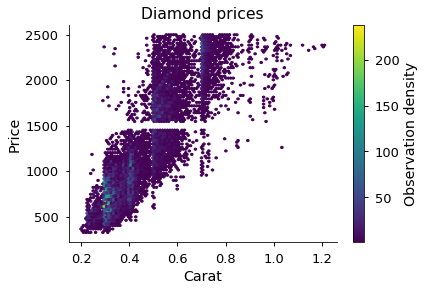

In [40]:
diamonds_subset = diamonds.loc[(diamonds['carat'] < 1.3) & (diamonds['price'] < 2500)]

fig, ax = plt.subplots()
hexbin = ax.hexbin('carat', 'price', data=diamonds_subset, mincnt=1)
sns.despine()
cax = fig.colorbar(hexbin)

cax.set_label('Observation density')
ax.set_title('Diamond prices')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')

Although this hexbin plot is a great way of visualizing the distributions, it could be valuable to compare it to the histograms for each the plotted variable.

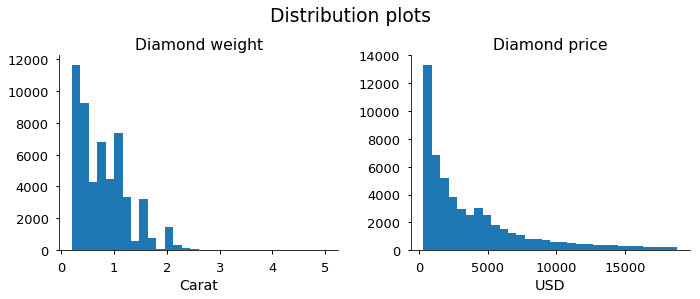

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Distribution plots', y=1.05)
sns.despine()

ax1.hist('carat', bins=30, data=diamonds) 
ax1.set_title('Diamond weight')
ax1.set_xlabel('Carat')

ax2.hist('price', bins=30, data=diamonds) 
ax2.set_title('Diamond price')
ax2.set_xlabel('USD')

fig.tight_layout()

Since visualizing two individual 1D distribution together with their joint 2D distribution is a common operation, `seaborn` has a built-in function to create a hexbin plot with histograms on the marginal axes.

/home/joel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


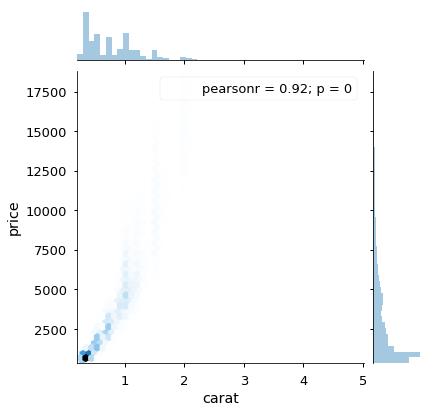

In [42]:
sns.jointplot(x='carat', y='price', data=diamonds, kind='hex')

This can be customized to appear more like the previous hexbin plots. Since `joinplot()` deals with both the hexbin and the histogram, the parameter names must be separated so that it is clear which plot they are referring to. This is done by passing them as dictionaries to the `joint_kws` and `marginal_kws` parameters ("kws" stands for "keywords").

/home/joel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


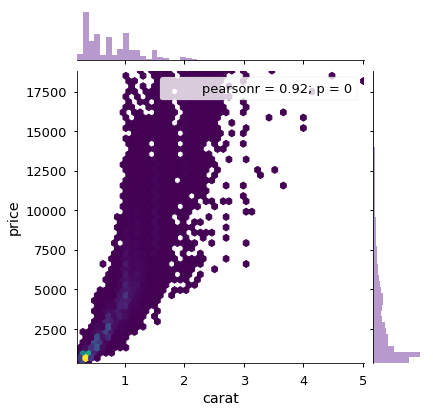

In [43]:
sns.jointplot(x='carat', y='price', data=diamonds, kind='hex', 
              joint_kws={'cmap':'viridis', 'mincnt':1},
              marginal_kws={'color': 'indigo'})

## Choosing informative plots for categorical data

When visualizing data it is important to explore different plotting options and reflect on which one best conveys the information within the data. In the following code cells, a sample data set is loaded from the `seaborn` data library in order to illustrate some advantages and disadvantages between categorical plot types. This is the same data as was used in lecture 1 and contains three different species of iris flowers and measurements of their sepals and petals.

In [44]:
import seaborn as sns

iris = sns.load_dataset('iris')
iris.groupby('species').mean()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


### Bar plots

A common visualization when comparing a groups is to create a barplot of the means of each group and plot them next to each other.

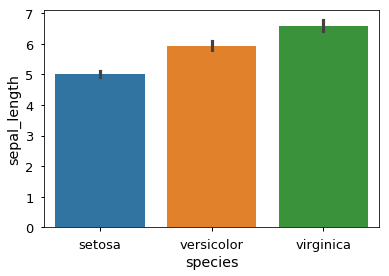

In [45]:
sns.barplot(x='species', y='sepal_length', data=iris)

This barplot shows the mean and the 95% confidence interval. Individual plotting functions in `seaborn` return an axes with the plotted elements. This returned axes object can be assigned to a variable name and customized just as previously in this lecture.

Text(0.5,0,'')

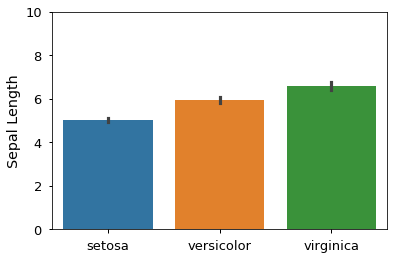

In [46]:
ax = sns.barplot(x='species', y='sepal_length', data=iris)

ax.set_ylim(0, 10)
ax.set_ylabel('Sepal Length')
ax.set_xlabel('')

Since the `seaborn` plotting functions returns a `matplotlib` axes object, these can be used with any `matplotlib` functions. For example, by creating a figure using `subplots()`, the `seaborn` plotting functions can be arranged as subplots in a grid. The syntax is slightly different from doing this with functions that are native to `matplotlib`, and the axes in which the `seaborn` function will plot needs to be specified with the `ax` parameter.

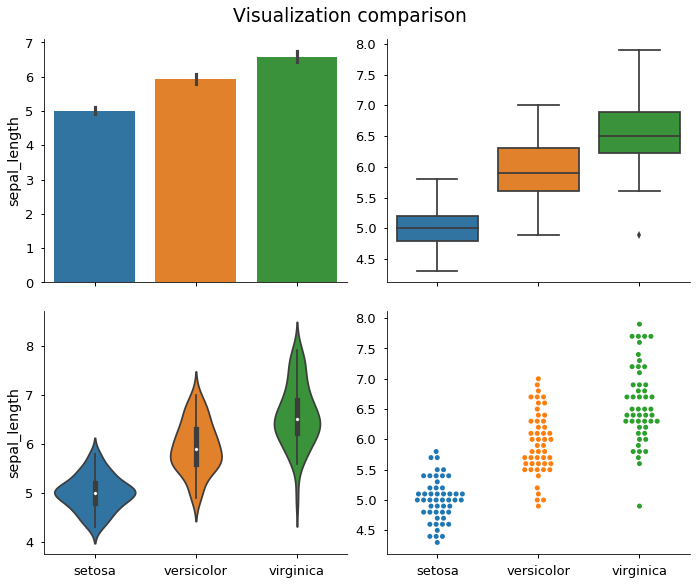

In [47]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
fig.suptitle('Visualization comparison', y=1.02) # `y` is used to place the title a little bit higher up
sns.despine()

sns.barplot(x='species', y='sepal_length', data=iris, ax=ax1)
sns.boxplot(x='species', y='sepal_length', data=iris, ax=ax2)
sns.violinplot(x='species', y='sepal_length', data=iris, ax=ax3)
sns.swarmplot(x='species', y='sepal_length', data=iris, ax=ax4)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax4.set_ylabel('')

fig.tight_layout()

>#### Challenge 3
>
>1. How many data points and/or distribution statistics are displayed in each of these plots 
>2. Out of the these plots, which one do you think is the most informative and why? Which is the most true to the underlying data?

### Pros and cons of different graph types

We will deepen the discussion around some of these ideas, in the context of the following plot:

![*Reproduced with permission from [Dr. Koyama's poster](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)*](./img/dynamite-bars.png)

*Reproduced with permission from [Dr. Koyama's poster](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)*

It is generally advisable to avoid "decorative" plot elements that do not convey extra information about the data, *especially* when such elements hide the real data. An early champion of this idea was Edward Tufte, who details how to reduce so called non-data ink and many other things in his book [The visual display of quantitative information](https://www.edwardtufte.com/tufte/books_vdqi). In the bar chart above, the only relevant information is given by the where the rectangles of the bars ends on the y-axis, the rest of it is unnecessary. Instead of using the rectangle's height, a simpler marker (circle, square, etc) could have been used to indicate the height on the y-axis. Note that the body of the rectangle is not representative for where the data lies, there are probably no data points close to 0, and several above the rectangle.

Barplots are especially misleading when used as data summaries, as in the
example above. In a summary plot, only two distribution parameters (a measure of
central tendency, e.g. the mean, and error, e.g. the standard deviation or a
confidence interval) are displayed, instead of showing all the individual data
points. This can be highly misleading, since different underlying distributions
can give rise to the same summary plot. We also have no idea of how many observations there are in each group. These
shortcomings become evident when comparing the barplot to the underlying
distributions that were used to create them:

![*Reproduced with permission from [Dr. Koyama's poster*](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)](./img/dynamite-vs-dists.png)

*Reproduced with permission from [Dr. Koyama's poster](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)*

Immediately, you can see that conclusions drawn from the barplot, such that A
and B have the same outcome, are factually incorrect. The distribution in D is
bimodal, so representing that with a mean would be like observing black and
white birds and conclude that the average bird color is grey, it's nonsensical.
If we would have planned our follow up experiments based on the barplot alone,
we would have been setting ourselves up for failure! Always be sceptical when
you see a barplot in a published paper, and think of how the underlying
distribution might look (note that barplots are more acceptable when used to
represents counts, proportion or percentages, where there is only one data point
per group in the data set).

Boxplots and violin plots are more meaningful data summaries as they represent more than just two distribution parameters (such as mean +/- sd). However, these can still be misleading and it is often the most appropriate to show each individual observation with a dot/hive/swarm plot, possibly combined with a superimposed summary plot or a marker for the mean or median *if* this additional information is useful. One exception, when it is not advisable to show all data points, is when the data set is gigantic and plotting each individual observation would oversaturate the chart. In that case, plot summary statistics or a 2D histogram (more on this later).

Here is an example of how a violinplot can be combined together with the individual observations in `seaborn`.

Text(0.5,0,'')

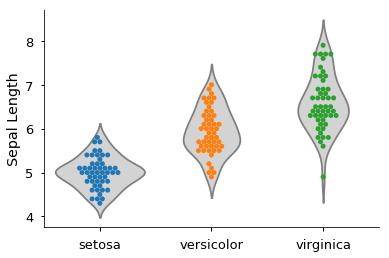

In [48]:
fig, ax = plt.subplots()
sns.despine()

sns.violinplot(x='species', y='sepal_length', data=iris,
               color='lightgrey', inner=None, ax=ax)
sns.swarmplot(x='species', y='sepal_length', data=iris,
              ax=ax) 
ax.set_ylabel('Sepal Length')
ax.set_xlabel('')

Plotting elements have a default order in which they appear. This can be changed by explicitly via the `zorder` parameter.

Text(0.5,0,'')

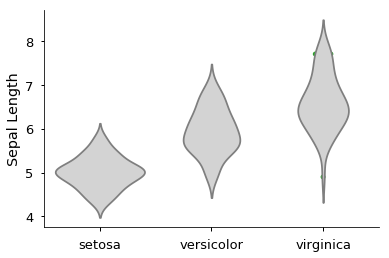

In [49]:
fig, ax = plt.subplots()
sns.despine()

sns.violinplot(x='species', y='sepal_length', data=iris,
               color='lightgrey', inner=None, ax=ax, zorder=10)
sns.swarmplot(x='species', y='sepal_length', data=iris,
              ax=ax, zorder=0) 
ax.set_ylabel('Sepal Length')
ax.set_xlabel('')

>#### Challenge 4
>
>1. So far, we've looked at the distribution of sepal length within species.  Try making a new plot to explore the distribution of another variable within each species.
>2. Combine a `stripplot()` with a `boxplot()`. Set the `jitter` parameter to distribute the dots so that they are not all on one line.

## Making plots accessible through suitable color choices

Colour blindness is common in the population, and red-green colour blindness in particular affects 8% of men and 0.5% of women. Guidelines for making your visualizations more accessible to people affected by colour blindness, will in many cases also improve the interpretability of your graphs for people who have standard color vision. Here are a couple of examples:

Don't use jet rainbow-coloured heatmaps. Jet colourmaps are often the default heatmap used in many visualization packages (you've probably seen them before). 

![](./img/heatmap.png)

Colour blind viewers are going to have a difficult time distinguishing the meaning of this heat map if some of the colours blend together.

![](./img/colourblind.png)

The jet colormap should be avoided for other reasons, including that the sharp transitions between colors introduces visual threshold levels that do not represent the underlying continuous data. Another issue is luminance, or brightness. For example, your eye is drawn to the yellow and cyan regions, because the luminance is higher. This can have the unfortunate effect of highlighting features in your data that don't actually exist, misleading your viewers! It also means that your graph is not going to translate well to greyscale in publication format.

More details about jet can be found in [this blog post](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/) and [this series of posts](https://mycarta.wordpress.com/2012/05/12/the-rainbow-is-dead-long-live-the-rainbow-part-1/). In general, when presenting continuous data, a perceptually uniform colormap is often the most suitable choice. This type of colormap ensures that equal steps in data are perceived as equal steps in color space. The human brain perceives changes in lightness as changes in the data much better than, for example, changes in hue. Therefore, colormaps which have monotonically increasing lightness through the colormap will be better interpreted by the viewer. More details and examples of such colormaps are available in the [`matplotlib` documentation](http://matplotlib.org/users/colormaps.html), and many of the core design principles are outlined in [this entertaining talk](https://www.youtube.com/watch?v=xAoljeRJ3lU).

The default colormap in `matplotlib` is `viridis` which to have monotonically increasing lightness throughout. There is also `cividis`, which is designed to look the same for common colorblindess as for people without colorblindness. Heatmaps is a good example on where color matters

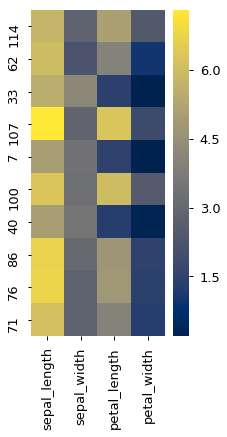

In [50]:
fig, ax = plt.subplots(figsize=(3, 6))
iris_heat = iris.iloc[:, :4].sample(10, random_state=0)
sns.heatmap(iris_heat, cmap='cividis', ax=ax)

Heatmaps are great when visualizing correlation matrices. Since correlations range from -1 to 1, it is suitable to use a divergent heatmap with two distinct colors centered around 0.

In [51]:
iris.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


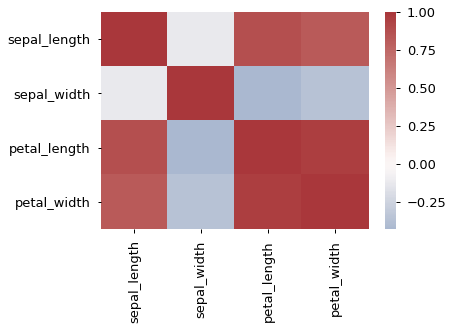

In [52]:
sns.heatmap(iris.corr(), center=0, cmap='vlag')

In a correlation matrix, the diagonal is a column's correlaiton with itself, so it is always perfect (1). The same values are mirrored above and below the diagonal.

Another approach to improve visualization clarity is to use different symbols for the groups and to change the color palette to one specifically designed to work well for common colorblindness.

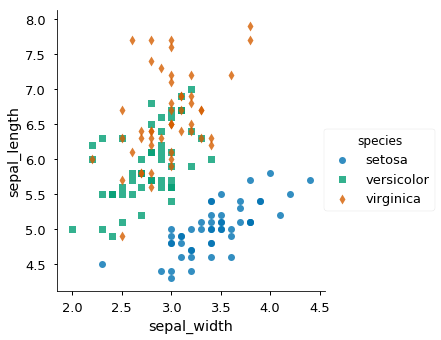

In [53]:
# To see all available palettes, set it to an empty string and view the error message
sns.lmplot(x='sepal_width', y='sepal_length', hue='species', data=iris,
           fit_reg=False, markers=['o', 's', 'd'], palette='colorblind')

>#### Challenge 5 (optional)
>
>1. Take one of the figures created previously and upload it to [this website](http://www.color-blindness.com/coblis-color-blindness-simulator/) to see how it  looks in the color blindness simulator.

### More general resources on plotting

- [Ten Simple Rules for Better Figures](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003833)
- [Finding the Right Color Palettes for Data Visualizations](https://blog.graphiq.com/finding-the-right-color-palettes-for-data-visualizations-fcd4e707a283)
- [Examples of bad graphs](https://www.biostat.wisc.edu/~kbroman/topten_worstgraphs/)
- [More examples of bad graphs and how to improve them](https://www.stat.auckland.ac.nz/~ihaka/120/Lectures/lecture03.pdf)
- [Wikipedia has a great article on misleading graphs](https://en.wikipedia.org/wiki/Misleading_graph)
- [Usability article about how to design for people with color blindness](http://blog.usabilla.com/how-to-design-for-color-blindness/)